## Quanvolution (PennyLane + PyTorch)
**논문 설정에 맞춘 구현**

In [1]:
# 필수 패키지 (이미 설치했다면 건너뛰세요)
try:
    import pennylane as qml
    import torch, torchvision
except Exception:
    %pip -q install pennylane torch torchvision
import os
import pennylane as qml
import torch, torchvision
import numpy as np
import copy
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
print('torch', torch.__version__, '| pennylane', qml.version())

torch 2.8.0+cpu | pennylane 0.42.3


### 모르는 부분 간단 정리
**CHANNELS**
다양하게 여러번 보는 느낌?
-> 중간 정도로(6~8) 설정해보고, 속도나 성능에 따라서 조절해보자

**Epochs**
다 본걸 다시 보는 느낌
-> 너무 커지면 과적합
-> 작게 설정해서 키워보면서 해보자

In [2]:
# 설정값 (논문 정렬)
TRAIN_COUNT = 4000     # 훈련 샘플 수. 
TEST_COUNT  = 1000     # 테스트 샘플 수
CHANNELS    = 6       # 양자 채널 수(4~12, 4의 배수로 해야하나?)
EPOCHS      = 30     # Epoch 수(5~20으로)
HIDDEN_UNITS= 128      # 은닉층 넓이 , 128일 때 0.95
BATCH_TRAIN = 128      # 훈련 배치 크기
BATCH_TEST  = 128      # 테스트 배치 크기
MAX_QNODE_BATCH = 64   # 패치별 QNode 호출의 내부 분할 크기
CACHE_DIR   = './quanv_cache_paper'
SEED        = 42
os.makedirs(CACHE_DIR, exist_ok=True)

torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
# 백엔드 선택 (lightning.qubit → default.qubit 폴백)
def make_device(wires=4):
    try:
        dev = qml.device('lightning.qubit', wires=wires)
        print('[Backend] lightning.qubit')
        return dev
    except Exception as e:
        print(f'[Backend] lightning.qubit 사용 불가 → default.qubit ({e})')
        dev = qml.device('default.qubit', wires=wires)
        print('[Backend] default.qubit')
        return dev

DEV = make_device(4)

[Backend] lightning.qubit


In [4]:
# ✅ 데이터 준비: MNIST 10×10
def load_mnist_10x10(train_count=TRAIN_COUNT, test_count=TEST_COUNT):
    tfm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((10,10)),
    ])
    train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=tfm)
    test_ds  = datasets.MNIST(root='./data', train=False, download=True, transform=tfm)
    x_train = torch.stack([train_ds[i][0] for i in range(train_count)])  # (N,1,10,10)
    y_train = torch.tensor([train_ds[i][1] for i in range(train_count)])
    x_test  = torch.stack([test_ds[i][0]  for i in range(test_count)])
    y_test  = torch.tensor([test_ds[i][1] for i in range(test_count)])
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_mnist_10x10()
print('data:', x_train.shape, x_test.shape)

data: torch.Size([4000, 1, 10, 10]) torch.Size([1000, 1, 10, 10])


In [5]:
def plot_sample(idx: int, split: str = "train"):
    
    X, Y = (x_train, y_train) if split == "train" else (x_test, y_test)
    if not (0 <= idx < len(X)):
        raise ValueError(f"idx 범위 초과: 0 <= idx < {len(X)}")

    img   = X[idx].squeeze(0).cpu()  # (10,10)
    label = int(Y[idx])

    plt.figure(figsize=(3, 3))
    plt.imshow(img, cmap="gray", vmin=0, vmax=1)
    plt.title(f"{split} idx={idx}, label={label}")
    plt.axis("off")
    plt.show()

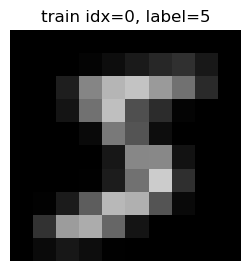

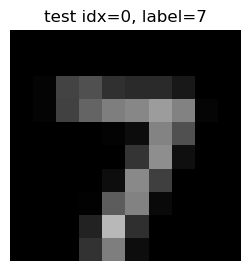

In [6]:
plot_sample(0, "train")
plot_sample(0, "test")

In [7]:
# 2×2 패치 → 4 큐빗 인코딩 + 얽힘 회로 + 랜덤 단일 큐빗 회전 (비학습형)
def random_weights(seed=0):
    rng = np.random.default_rng(seed)
    return np.array(rng.uniform(0, 2*np.pi, size=(4,2)), dtype=np.float32)  # 각 큐빗 (RZ,RX)

@qml.qnode(DEV, interface='torch')
def patch_qnode(pix4, weights):
    # 데이터 인코딩: 입력 ∈ [0,1] → RX(pi*x)
    for w in range(4):
        qml.RX(np.pi * pix4[w], wires=w)
    # 얽힘 (CZ 체인)
    qml.CZ(wires=[0,1]); qml.CZ(wires=[2,3]); qml.CZ(wires=[0,2]); qml.CZ(wires=[1,3])
    # 랜덤 단일 큐빗 회전
    for w in range(4):
        qml.RZ(weights[w,0], wires=w)
        qml.RX(weights[w,1], wires=w)
    # 4개 큐빗 Z 기대값 (튜플로 반환 → 바깥에서 torch.stack)
    return (
        qml.expval(qml.PauliZ(0)),
        qml.expval(qml.PauliZ(1)),
        qml.expval(qml.PauliZ(2)),
        qml.expval(qml.PauliZ(3)),
    )

WEIGHTS = [torch.tensor(random_weights(1000+c), dtype=torch.float32) for c in range(CHANNELS)]

In [8]:
# 패치 추출 (2×2, stride 2) → (N,5,5,4)
def extract_patches_2x2_stride2(x):  # x: (N,1,10,10)
    N = x.shape[0]
    patches = torch.zeros((N,5,5,4), dtype=torch.float32)
    for i in range(5):
        for j in range(5):
            patch = x[:, :, 2*i:2*i+2, 2*j:2*j+2].reshape(N, 4)
            patches[:, i, j, :] = patch
    return patches

In [9]:
# Quanvolution 변환: (N,1,10,10) → (N,5,5, CHANNELS*4)
@torch.no_grad()
def quanv_transform(x, channels=CHANNELS, max_batches=MAX_QNODE_BATCH, cache_key=None):
    # 캐시 로드
    if cache_key is not None:
        fpath = os.path.join(CACHE_DIR, cache_key)
        if os.path.isfile(fpath):
            npz = np.load(fpath)
            feat = torch.tensor(npz['feat'])
            return feat

    patches = extract_patches_2x2_stride2(x)  # (N,5,5,4)
    N = patches.shape[0]
    feats = torch.zeros((N,5,5,channels*4), dtype=torch.float32)
    for i in range(5):
        for j in range(5):
            p = patches[:, i, j, :]  # (N,4)
            for ch in range(channels):
                out_chunks = []
                for s in range(0, N, max_batches):
                    batch = p[s:s+max_batches]
                    vals = []
                    for b in batch:
                        exps = patch_qnode(b, WEIGHTS[ch])       # tuple of 4 scalars
                        exps = torch.stack(exps)                  # (4,)
                        vals.append(exps.unsqueeze(0))            # (1,4)
                    out_chunks.append(torch.cat(vals, dim=0))     # (bs,4)
                combined = torch.cat(out_chunks, dim=0)           # (N,4)
                feats[:, i, j, ch*4:(ch+1)*4] = combined
    # 캐시 저장
    if cache_key is not None:
        np.savez_compressed(os.path.join(CACHE_DIR, cache_key), feat=feats.numpy())
    return feats

train_key = f'train_feat_C{CHANNELS}_N{TRAIN_COUNT}_4qubits.npz'
test_key  = f'test_feat_C{CHANNELS}_N{TEST_COUNT}_4qubits.npz'
x_train_feat = quanv_transform(x_train, channels=CHANNELS, cache_key=train_key)
x_test_feat  = quanv_transform(x_test,  channels=CHANNELS, cache_key=test_key)
print('features:', x_train_feat.shape, x_test_feat.shape)

features: torch.Size([4000, 5, 5, 24]) torch.Size([1000, 5, 5, 24])


In [10]:
# 분류기: Flatten → Dense(128) → Dense(10)
class Classifier(nn.Module):
    def __init__(self, channels=CHANNELS, hidden=HIDDEN_UNITS):
        super().__init__()
        self.fc1 = nn.Linear(5*5*channels*4, hidden)  # 4qubits 유지
        self.drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden, 10)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        return self.fc2(x)

def evaluate(model, loader):
    model.eval(); correct = total = 0
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb)
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.numel()
    return correct/total

In [11]:
idx = torch.arange(len(x_train_feat))
tr_idx, va_idx = train_test_split(
    idx.numpy(), test_size=0.1, random_state=SEED,
    stratify=y_train.numpy()
)
tr_idx, va_idx = torch.tensor(tr_idx), torch.tensor(va_idx)

train_loader = DataLoader(
    TensorDataset(x_train_feat[tr_idx], y_train[tr_idx]),
    batch_size=BATCH_TRAIN, shuffle=True
)
val_loader = DataLoader(
    TensorDataset(x_train_feat[va_idx], y_train[va_idx]),
    batch_size=BATCH_TEST, shuffle=False
)
test_loader = DataLoader(
    TensorDataset(x_test_feat, y_test),
    batch_size=BATCH_TEST, shuffle=False
)

In [12]:
WARMUP_EPOCHS   = 30             # 최소 N epoch 전에는 멈추지 않음
SCHED_PATIENCE  = 5                # Plateau 5epoch면 LR 감소
ES_PATIENCE     = 3 * SCHED_PATIENCE  # LR 감소 뒤 회복 기회 충분히(=15)
MIN_DELTA       = 1e-4             # 이만큼만 좋아져도 '개선'으로 인정

clf = Classifier(CHANNELS, HIDDEN_UNITS)
opt = torch.optim.Adam(clf.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()
# sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     opt, mode='min', factor=0.5, patience=SCHED_PATIENCE, verbose=False
# )

train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val = float('inf')
best_state = None
wait = 0

def pass_epoch(model, loader, train_mode: bool):
    model.train() if train_mode else model.eval()
    tot_loss, tot_correct, tot_cnt = 0.0, 0, 0
    with torch.set_grad_enabled(train_mode):
        for xb, yb in loader:
            logits = model(xb)
            loss = loss_fn(logits, yb)
            if train_mode:
                opt.zero_grad()
                loss.backward()
                opt.step()
            tot_loss   += loss.item() * xb.size(0)
            tot_correct+= (logits.argmax(1) == yb).sum().item()
            tot_cnt    += xb.size(0)
    return tot_loss/tot_cnt, tot_correct/tot_cnt

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = pass_epoch(clf, train_loader, True)
    va_loss, va_acc = pass_epoch(clf, val_loader,   False)

    train_losses.append(tr_loss); train_accs.append(tr_acc)
    val_losses.append(va_loss);   val_accs.append(va_acc)

    # sched.step(va_loss)
    print(f"[{ep:02d}/{EPOCHS}] train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f} | lr {opt.param_groups[0]['lr']:.2e}")

    # 개선 판단 + EarlyStopping
    if va_loss < best_val - MIN_DELTA:
        best_val = va_loss
        best_state = copy.deepcopy(clf.state_dict())
        wait = 0
    else:
        wait += 1
        # 워밍업 전에는 멈추지 않음
        if ep >= WARMUP_EPOCHS and wait >= ES_PATIENCE:
            print(f"Early stop at epoch {ep} (best val loss {best_val:.4f})")
            break

# best 가중치 복원
if best_state is not None:
    clf.load_state_dict(best_state)

# 최종 테스트
clf.eval()
test_correct = 0; test_cnt = 0
with torch.no_grad():
    for xb, yb in test_loader:
        lg = clf(xb)
        test_correct += (lg.argmax(1) == yb).sum().item()
        test_cnt     += xb.size(0)
print(f"[TEST] acc = {test_correct/test_cnt:.4f}")

[01/30] train 1.8183/0.491 | val 1.3261/0.625 | lr 1.00e-03
[02/30] train 1.0764/0.717 | val 0.8669/0.752 | lr 1.00e-03
[03/30] train 0.7622/0.787 | val 0.6745/0.810 | lr 1.00e-03
[04/30] train 0.6440/0.813 | val 0.6231/0.820 | lr 1.00e-03
[05/30] train 0.5560/0.839 | val 0.5481/0.848 | lr 1.00e-03
[06/30] train 0.4880/0.865 | val 0.5088/0.863 | lr 1.00e-03
[07/30] train 0.4641/0.868 | val 0.4861/0.865 | lr 1.00e-03
[08/30] train 0.4304/0.876 | val 0.4680/0.880 | lr 1.00e-03
[09/30] train 0.4039/0.883 | val 0.4518/0.873 | lr 1.00e-03
[10/30] train 0.3720/0.892 | val 0.4478/0.875 | lr 1.00e-03
[11/30] train 0.3541/0.899 | val 0.4467/0.880 | lr 1.00e-03
[12/30] train 0.3438/0.900 | val 0.4163/0.887 | lr 1.00e-03
[13/30] train 0.3257/0.905 | val 0.4199/0.882 | lr 1.00e-03
[14/30] train 0.3167/0.903 | val 0.3959/0.897 | lr 1.00e-03
[15/30] train 0.3065/0.909 | val 0.4082/0.897 | lr 1.00e-03
[16/30] train 0.2994/0.916 | val 0.4050/0.885 | lr 1.00e-03
[17/30] train 0.2901/0.916 | val 0.3962/

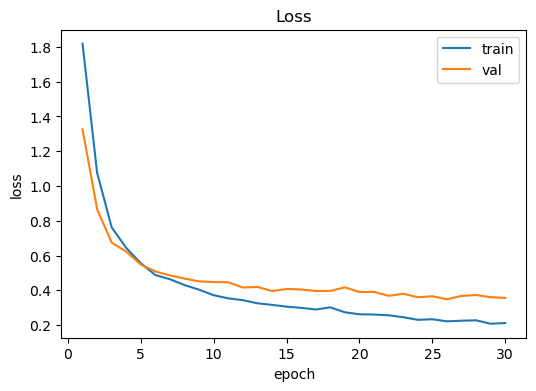

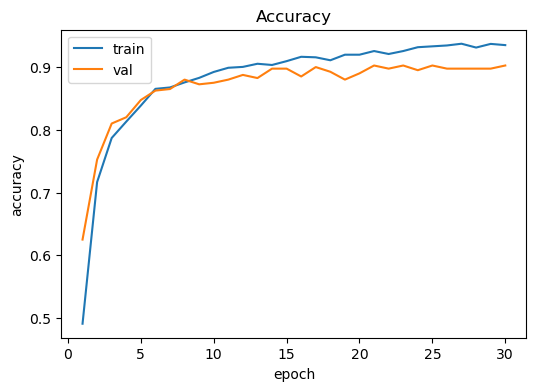

In [13]:

epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(6,4))
plt.plot(epochs, train_losses, label="train")
plt.plot(epochs, val_losses,   label="val")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, train_accs, label="train")
plt.plot(epochs, val_accs,   label="val")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.title("Accuracy")
plt.show()